# Tutorial 07

## fitting tests pure CMB

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.methods.fit import *
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 20
APOSCALE = 6.
LMIN = 30
LMAX = 200
PSBIN = 5
FREQS = [23,95,150,353]
FWHM = [np.deg2rad(52.8/60.),np.deg2rad(19./60.),np.deg2rad(11./60.),np.deg2rad(4.94/60.)]
KWARGS = {'nlive':1000}

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])

mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
fidcmb = np.empty((NSAMP,3,mapcmb.shape[1]),dtype=np.float32)
for i in range(NSAMP):
    fidcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP,3,vmap353.shape[1]))*np.sqrt(vmap353)

### pure CMB signal

1985it [02:41, 12.30it/s, +400 | bound: 2 | nc: 1 | ncall: 15328 | eff(%): 15.560 | loglstar:   -inf < -10.347 <    inf | logz: -14.221 +/-  0.112 | dlogz:  0.001 >  0.409]


G $\chi^2_{min}$ 20.694050598671225


2052it [11:57,  2.86it/s, +400 | bound: 2 | nc: 1 | ncall: 15993 | eff(%): 15.332 | loglstar:   -inf < -10.211 <    inf | logz: -14.254 +/-  0.116 | dlogz:  0.001 >  0.409]


HL $\chi^2_{min}$ 20.421816252441367
CPU times: user 2h 28min 53s, sys: 5min 31s, total: 2h 34min 24s
Wall time: 19min 32s


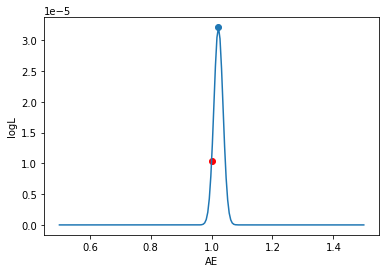

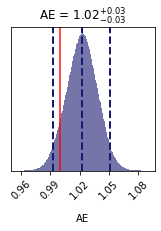

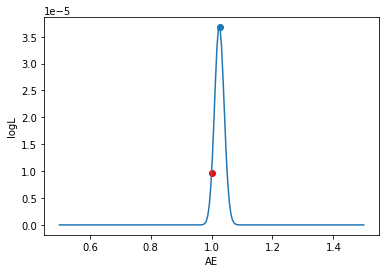

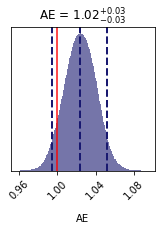

In [2]:
%%time

TARGET = ('EE',)
MODEL = 'acmb'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#------------------------------------------------------------------

pp.engine = gaussfit(pp.data_bp,
                     np.mean(pp.fiducial_bp,axis=0),
                     np.mean(pp.noise_bp,axis=0),
                     pp.covmat,
                     pp.background_obj,
                     pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
loglg0 = pp.engine.loglikeli(pp.engine.background.bandpower())

posAE = np.linspace(0.5,1.5,200)
loglAEg = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEg))
ax.scatter(posAE[np.where(loglAEg == np.amax(loglAEg))],np.exp(np.amax(loglAEg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})
print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

#------------------------------------------------------------------

pp.engine = hlfit(pp.data_bp,
                  np.mean(pp.fiducial_bp,axis=0),
                  np.mean(pp.noise_bp,axis=0),
                  pp.covmat,
                  pp.background_obj,
                  pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
loglh0 = pp.engine.loglikeli(pp.engine.background.bandpower())

loglAEh = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEh))
ax.scatter(posAE[np.where(loglAEh == np.amax(loglAEh))],np.exp(np.amax(loglAEh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

2636it [02:57, 14.82it/s, +400 | bound: 4 | nc: 1 | ncall: 16527 | eff(%): 18.370 | loglstar:   -inf < -9.219 <    inf | logz: -14.762 +/-  0.151 | dlogz:  0.001 >  0.409]


G $\chi^2_{min}$ 18.438107112680374


2623it [13:13,  3.31it/s, +400 | bound: 4 | nc: 1 | ncall: 17127 | eff(%): 17.650 | loglstar:   -inf < -9.228 <    inf | logz: -14.741 +/-  0.150 | dlogz:  0.001 >  0.409]


HL $\chi^2_{min}$ 18.455374398069253
CPU times: user 2h 42min 36s, sys: 6min 13s, total: 2h 48min 49s
Wall time: 21min 22s


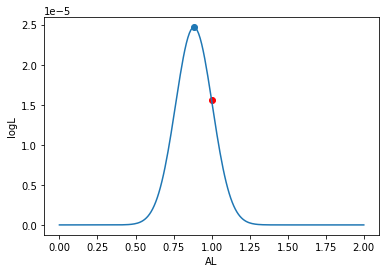

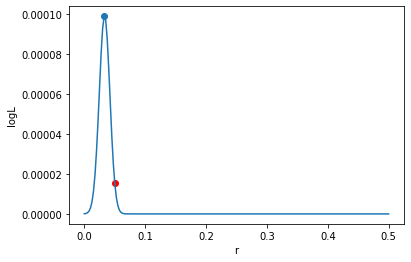

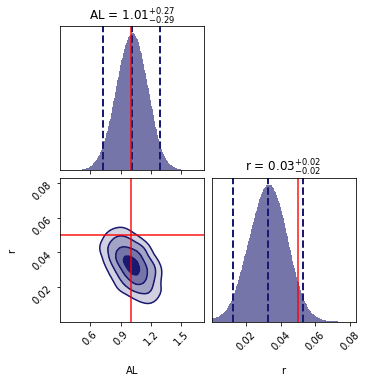

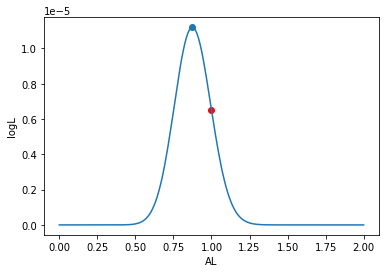

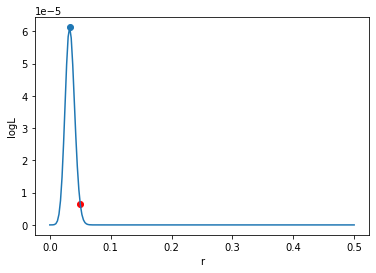

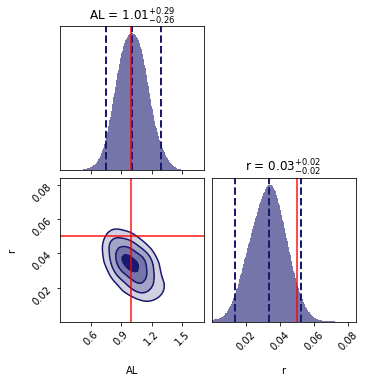

In [3]:
%%time

TARGET = ('BB',)

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#------------------------------------------------------------------

pp.engine = gaussfit(pp.data_bp,
                     np.mean(pp.fiducial_bp,axis=0),
                     np.mean(pp.noise_bp,axis=0),
                     pp.covmat,
                     pp.background_obj,
                     pp.foreground_obj)

pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglg0 = pp.engine.loglikeli(pp.engine.background.bandpower())

posAL = np.linspace(0,2,200)
loglALg = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALg))
ax.scatter(posAL[np.where(loglALg == np.amax(loglALg))],np.exp(np.amax(loglALg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AL': 1.})
posR = np.linspace(0,0.5,200)
loglRg = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRg))
ax.scatter(posR[np.where(loglRg == np.amax(loglRg))],np.exp(np.amax(loglRg)))
ax.scatter(0.05,np.exp(loglg0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})
print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

#------------------------------------------------------------------

pp.engine = hlfit(pp.data_bp,
                  np.mean(pp.fiducial_bp,axis=0),
                  np.mean(pp.noise_bp,axis=0),
                  pp.covmat,
                  pp.background_obj,
                  pp.foreground_obj)

pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglh0 = pp.engine.loglikeli(pp.engine.background.bandpower())

pp.engine.background.reset({'AE': 1.})
loglALh = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALh))
ax.scatter(posAL[np.where(loglALh == np.amax(loglALh))],np.exp(np.amax(loglALh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AL': 1.})
loglRh = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRh))
ax.scatter(posR[np.where(loglRh == np.amax(loglRh))],np.exp(np.amax(loglRh)))
ax.scatter(0.05,np.exp(loglh0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

3693it [03:08, 19.56it/s, +400 | bound: 9 | nc: 1 | ncall: 19586 | eff(%): 20.898 | loglstar:   -inf < -12.474 <    inf | logz: -20.711 +/-  0.194 | dlogz:  0.001 >  0.409]


G $\chi^2_{min}$ 24.94843539881211


3563it [15:49,  3.75it/s, +400 | bound: 8 | nc: 1 | ncall: 19289 | eff(%): 20.545 | loglstar:   -inf < -12.285 <    inf | logz: -20.193 +/-  0.189 | dlogz:  0.001 >  0.409]


HL $\chi^2_{min}$ 24.570188456098812
CPU times: user 3h 24min 43s, sys: 7min 31s, total: 3h 32min 14s
Wall time: 26min 55s


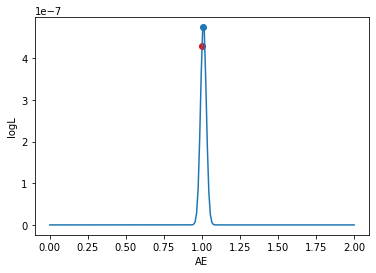

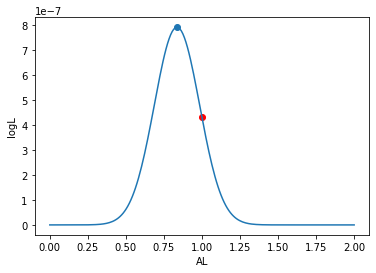

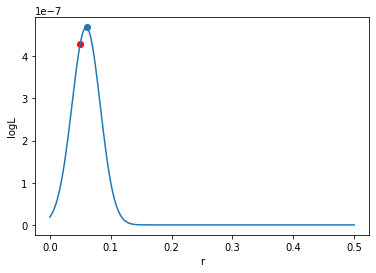

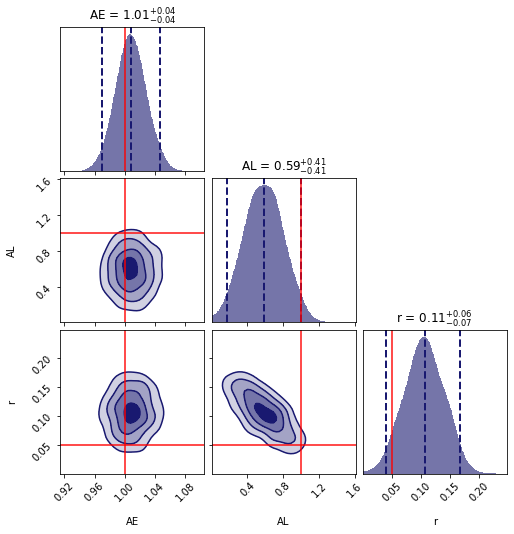

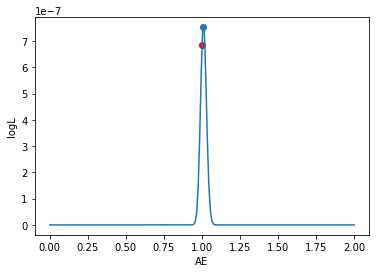

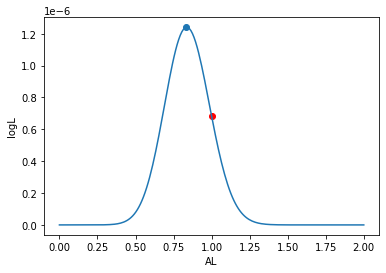

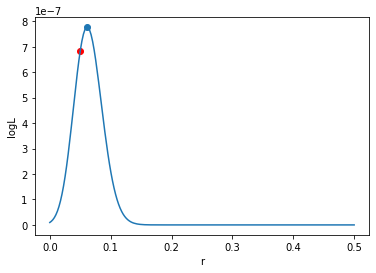

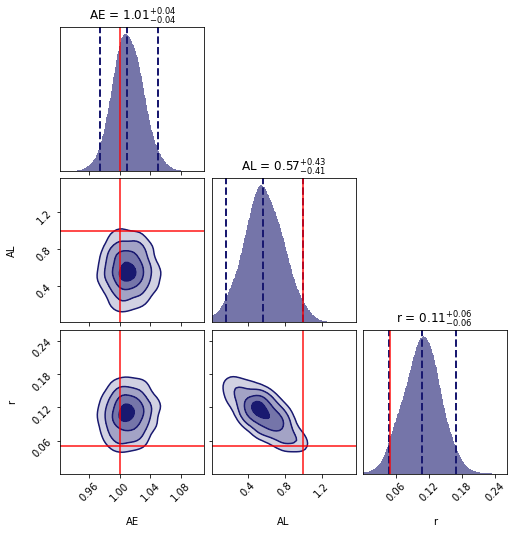

In [4]:
%%time

TARGET = ('EE','BB')

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#------------------------------------------------------------------

pp.engine = gaussfit(pp.data_bp,
                     np.mean(pp.fiducial_bp,axis=0),
                     np.mean(pp.noise_bp,axis=0),
                     pp.covmat,
                     pp.background_obj,
                     pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglg0 = pp.engine.loglikeli(pp.engine.background.bandpower())

#
posAE = np.linspace(0,2,200)
loglAEg = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEg))
ax.scatter(posAE[np.where(loglAEg == np.amax(loglAEg))],np.exp(np.amax(loglAEg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
posAL = np.linspace(0,2,200)
loglALg = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALg))
ax.scatter(posAL[np.where(loglALg == np.amax(loglALg))],np.exp(np.amax(loglALg)))
ax.scatter(1.,np.exp(loglg0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
posR = np.linspace(0,0.5,200)
loglRg = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRg[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRg))
ax.scatter(posR[np.where(loglRg == np.amax(loglRg))],np.exp(np.amax(loglRg)))
ax.scatter(0.05,np.exp(loglg0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})
print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

#------------------------------------------------------------------

pp.engine = hlfit(pp.data_bp,
                  np.mean(pp.fiducial_bp,axis=0),
                  np.mean(pp.noise_bp,axis=0),
                  pp.covmat,
                  pp.background_obj,
                  pp.foreground_obj)

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
pp.engine.background.reset({'r': 0.05})
loglh0 = pp.engine.loglikeli(pp.engine.background.bandpower())

loglAEh = np.zeros_like(posAE)
for i in range(len(posAE)):
    pp.engine.background.reset({'AE': posAE[i]})
    loglAEh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAE,np.exp(loglAEh))
ax.scatter(posAE[np.where(loglAEh == np.amax(loglAEh))],np.exp(np.amax(loglAEh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AE')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
loglALh = np.zeros_like(posAL)
for i in range(len(posAL)):
    pp.engine.background.reset({'AL': posAL[i]})
    loglALh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posAL,np.exp(loglALh))
ax.scatter(posAL[np.where(loglALh == np.amax(loglALh))],np.exp(np.amax(loglALh)))
ax.scatter(1.,np.exp(loglh0),color='red')
ax.set_xlabel('AL')
ax.set_ylabel('logL')

pp.engine.background.reset({'AE': 1.})
pp.engine.background.reset({'AL': 1.})
loglRh = np.zeros_like(posR)
for i in range(len(posR)):
    pp.engine.background.reset({'r': posR[i]})
    loglRh[i] = pp.engine.loglikeli(pp.engine.background.bandpower())
    
fig,ax = plt.subplots()
ax.plot(posR,np.exp(loglRh))
ax.scatter(posR[np.where(loglRh == np.amax(loglRh))],np.exp(np.amax(loglRh)))
ax.scatter(0.05,np.exp(loglh0),color='red')
ax.set_xlabel('r')
ax.set_ylabel('logL')

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

end